In [106]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from classiq import *
from classiq.applications.iqae.iqae import IQAE

In [107]:
# How many qubits we want the quantum circuit to be
num_qubits = 7

# Mu (μ) represents the Average
mu = 0.7

# Sigma (σ) represents the Standard Deviation
sigma = 0.13

# The Alpha (α) parameter represents the probability in which P(X > v) = 1 - α
ALPHA = 0.05

# Find Alpha in a given precision
TOLERANCE = ALPHA / 10


def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))


# %%
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


Value at risk at 5%: 1.6237536271497186


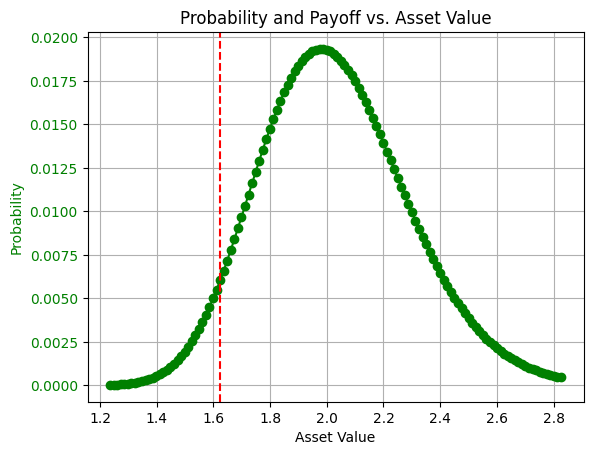

In [108]:
probs = (probs / np.sum(probs)).tolist()

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value")
ax1.set_ylabel("Probability", color="g")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

VAR = 0
# Find the value at risk ALPHA of grid_points
accumulated_value = 0

for index in range(len(probs)):
    accumulated_value += probs[index]
    if accumulated_value > ALPHA:
        VAR = grid_points[index]
        break

print(f"Value at risk at {int(ALPHA*100)}%: {VAR}")

# Plot the vertical line of VaR at 5%
ax1.axvline(x=VAR, color="r", linestyle="--", label="VaR at 5%")

In [109]:
def get_initial_index():
    return int(2**num_qubits) // 4

In [110]:
def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

In [111]:
# This function calculates the alpha classically given the index and the list of probabilities


def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

In [112]:
# This is the main Value at Risk function, which gets the required probability (required_alpha), the index and the alpha calculation function
# We aim to use calc_alpha defined above


def print_status(v, alpha_v, search_size, index):
    print(f"v: {v}, alpha_v: {alpha_v}")
    print(f"{search_size=}")
    print(f"{index=}")
    print("------------------------")


def print_results(grid_points, index, probs):
    print(f"Value at risk at {ALPHA*100}%: {grid_points[index]})")
    global VAR
    print(f"Real VaR", VAR)
    return index

def value_at_risk(required_alpha, index, epsilon, calc_alpha_func):

    max_index = len(probs) - 1
    search_size = max_index // 2
    var_history = [probs[index]]
    v, _, _ = calc_alpha_func(index, epsilon, probs)
    total_calls = 0

    while (not np.isclose(v, required_alpha, atol=epsilon)) and search_size > 0:
        v = probs[index]

        alpha_hat, ci, calls = calc_alpha_func(index, epsilon, probs)
        low, high = ci
        total_calls += calls

        print(f"index={index}, v={v:.6f}, F≈{alpha_hat:.4f}, CI={ci}")

        if high < required_alpha:
            # Too far left → move right
            index = min(index + search_size, max_index)

        elif low > required_alpha:
            # Too far right → move left
            index = max(index - search_size, 0)

        # shrink step size
        search_size //= 2

        var_history.append(probs[index])

    # Calculate RMSE
    # rmse = np.sqrt(np.mean((np.array(var_history) - VAR)**2))

    return probs[index], total_calls


In [113]:
@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)


@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [114]:
written_qmod = False


def calc_alpha_quantum(index: int, epsilon: float, probs: list[float]):

    # Global variable
    global GLOBAL_INDEX
    GLOBAL_INDEX = index

    # Creation of the model, given the constratins and the circuit preferences
    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits)
    )

    qprog = iqae.get_qprog()

    global written_qmod
    qmod = iqae.get_model()
    if not written_qmod:
        written_qmod = True
        show(qprog)

    iqae_res = iqae.run(epsilon=epsilon, alpha=0.01)
    calls = iqae_res.iterations_data[-1].grover_iterations

    # Result of the iterative QAE
    # iqae_res = res[0].value
    measured_payoff = iqae_res.estimation
    confidence_interval = np.array(
        [interval for interval in iqae_res.confidence_interval]
    )
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", confidence_interval)
    return measured_payoff, confidence_interval, calls

In [115]:
index = get_initial_index()

In [ ]:
# Instead of samples, iterate over target precisions
precisions = [0.5, 0.1, 0.1, 0.05, 0.01, 0.005, 0.001]
actual_oracle_calls = []

for eps_target in precisions:
    # Run your value_at_risk using eps_target as the epsilon
    var, calls = value_at_risk(ALPHA, index, eps_target, calc_alpha_quantum)
    actual_oracle_calls.append(calls)

Quantum program link: https://platform.classiq.io/circuit/39435sxnbXPlIYJrjUsINnA3w4Y


c:\Users\gurgl\miniconda3\envs\quantum\Lib\site-packages\classiq\interface\applications\iqae\generic_iqae.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(2 * self._max_rounds / self._alpha)
c:\Users\gurgl\miniconda3\envs\quantum\Lib\site-packages\classiq\interface\applications\iqae\generic_iqae.py:181: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(


In [ ]:
print(actual_oracle_calls)

[0, 0, 0, 0, 70, 125, 803]


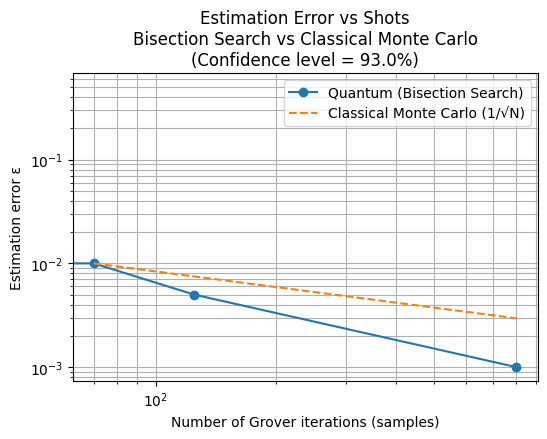

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

actual_oracle_calls = np.array(actual_oracle_calls)

# Classical Monte Carlo reference (O(1/sqrt(N)))

C = precisions[4] * np.sqrt(actual_oracle_calls[actual_oracle_calls != 0][0])  # match first data point

eps_mc = C / np.sqrt(actual_oracle_calls[actual_oracle_calls != 0])



plt.figure(figsize=(6, 4))



plt.loglog(actual_oracle_calls, precisions, 'o-', label="Quantum (Bisection Search)")

plt.loglog(actual_oracle_calls[actual_oracle_calls != 0], eps_mc, '--', label="Classical Monte Carlo (1/√N)")



plt.xlabel("Number of Grover iterations (samples)")

plt.ylabel("Estimation error ε")

plt.title(f"Estimation Error vs Shots\nBisection Search vs Classical Monte Carlo\n(Confidence level = {(1-ALPHA)*100.}%)")

plt.grid(True, which="both")

plt.legend()



plt.show()